# Binary classification Scikit-Learn model training. Run remotely via Azure Machine Learning Compute
_**This notebook showcases the training/creation of a Binary classification model training and predictions using Scikit-Learn on an Azure Machine Leanrning Compute Target (AMLCompute).**_


## Check versions

In [1]:
# Check versions
import azureml.core
import sklearn
import joblib
import pandas

print("Azure SDK version:", azureml.core.VERSION)
print('scikit-learn version is {}.'.format(sklearn.__version__))
print('joblib version is {}.'.format(joblib.__version__))
print('pandas version is {}.'.format(pandas.__version__))

Azure SDK version: 1.0.76
scikit-learn version is 0.20.3.
joblib version is 0.14.0.
pandas version is 0.23.4.


## Setup and connect to AML Workspace

In [2]:
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')


cesardl-automl-northcentralus-ws
automlpmdemo
northcentralus
102a16c3-37d3-48a8-9237-4c9b1e8e80e0


## Create An Experiment

**Experiment** is a logical container in an Azure ML Workspace. It hosts run records which can include run metrics and output artifacts from your experiments.

In [3]:
from azureml.core import Experiment
experiment_name = 'classif-attrition-amlcompute'
experiment = Experiment(workspace=ws, name=experiment_name)

## Introduction to AmlCompute

Azure Machine Learning Compute is managed compute infrastructure that allows the user to easily create single to multi-node compute of the appropriate VM Family. It is created **within your workspace region** and is a resource that can be used by other users in your workspace. It autoscales by default to the max_nodes, when a job is submitted, and executes in a containerized environment packaging the dependencies as specified by the user. 

Since it is managed compute, job scheduling and cluster management are handled internally by Azure Machine Learning service. 

For more information on Azure Machine Learning Compute, please read [this article](https://docs.microsoft.com/azure/machine-learning/service/how-to-set-up-training-targets#amlcompute)

**Note**: As with other Azure services, there are limits on certain resources (for eg. AmlCompute quota) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

### Create project directory and copy the training script into the project directory

Create a directory that will contain all the necessary code from your local machine that you will need access to on the remote resource. This includes the training script, and any additional files your training script depends on

In [185]:
import os
import shutil

project_folder = './classif-attrition-amlcompute'
os.makedirs(project_folder, exist_ok=True)

# Copy the training script into the project directory
shutil.copy('train.py', project_folder)

'./classif-attrition-amlcompute/train.py'

### Fetch the compute target 

We are going to use the compute target you had created before (make sure you provide the same name here in the variable `cpu_cluster_name`. 

In [186]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cluster_name = "cesardl-cpu-clus"

cluster = ws.compute_targets[cluster_name]

## (Option A.) Configure & Run using an Estimator with specific pkgs versions

In [165]:
from azureml.train.estimator import Estimator
from azureml.train.sklearn import SKLearn

pip_packages = [
                'azureml-defaults==1.0.76', 'azureml-core==1.0.76', 'azureml-telemetry==1.0.76',
                'azureml-dataprep==1.1.31', 'joblib==0.14.0', 'sklearn-pandas==1.7.0', 'pandas==0.23.4' 
               ]

script_params = {
    '--solver': 'liblinear',
    '--penalty': 'l2'
}

# Using SKLearn estimator class
estimator = SKLearn(source_directory=project_folder, 
                    script_params=script_params,
                    compute_target=cluster,
                    entry_script='train.py',
                    pip_packages=pip_packages,
                    conda_packages=['scikit-learn==0.20.3'],
                    inputs=[ws.datasets['IBM-Employee-Attrition'].as_named_input('attrition')])

# Using plain Estimator class
# estimator = Estimator(source_directory=project_folder, 
#                        script_params=script_params,
#                        compute_target=cluster,
#                        entry_script='train.py',
#                        pip_packages=pip_packages,
#                        conda_packages=['scikit-learn==0.20.3'],
#                        inputs=[ws.datasets['IBM-Employee-Attrition'].as_named_input('attrition')])

run = experiment.submit(estimator)
run


WARNING - You have specified to install packages in your run. Note that you have overridden Azure ML's installation of the following packages: ['joblib', 'scikit-learn']. We cannot guarantee image build will succeed.


Experiment,Id,Type,Status,Details Page,Docs Page
classif-attrition-amlcompute,classif-attrition-amlcompute_1578621538_f13ae2ba,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


## (Option B.) Configure & Run using RunConfig & Environment

### List Environments and packages in my workspace

In [63]:
from azureml.core import Environment

envs = Environment.list(workspace=ws)

# for env in envs:
#    if env.startswith("AzureML"):
#        print("Name",env)
#        print("packages", envs[env].python.conda_dependencies.serialize_to_string())
        
# Use curated environment from AML named "AzureML-Tutorial"
environment = Environment.get(workspace=ws, name="AzureML-Tutorial")
# restored_environment = Environment.get(workspace=ws,name="myenv",version="1")

# (B) from azureml.core import Run
# (B) Run.get_environment()

In [64]:
# Add training script to run config
from azureml.core import ScriptRunConfig, RunConfiguration, Experiment

runconfig = ScriptRunConfig(source_directory=project_folder, 
                            script="train.py",
                            arguments=[ws.datasets['IBM-Employee-Attrition'].as_named_input('attrition')]
                           )

# Attach compute target to run config
runconfig.run_config.target = cluster
# runconfig.run_config.target = "local"

# Attach environment to run config
runconfig.run_config.environment = environment

# RunConfig "way": Submit the Experiment Run to the AML Compute
# Submit run 
run = experiment.submit(runconfig)
run

Experiment,Id,Type,Status,Details Page,Docs Page
classif-attrition-amlcompute,classif-attrition-amlcompute_1578615922_0af37e8f,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


## Monitor Run

In [166]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'NOTSET',…

Note: if you need to cancel a run, you can follow [these instructions](https://aka.ms/aml-docs-cancel-run).

#### Get log results upon completion
Model training and monitoring happen in the background. Wait until the model has finished training before you run more code. Use wait_for_completion to show when the model training is finished:

In [66]:
# run.wait_for_completion(show_output=True)  # specify True for a verbose log

## (Option C.) Configure and Run with Intelligent hyperparameter tuning (HyperDrive with Estimator)
The adjustable parameters that govern the training process are referred to as the **hyperparameters** of the model. The goal of hyperparameter tuning is to search across various hyperparameter configurations and find the configuration that results in the best performance.

To demonstrate how Azure Machine Learning can help you automate the process of hyperarameter tuning, we will launch multiple runs with different values for numbers in the sequence. First let's define the parameter space using random sampling.

### Create a hyperparameter sweep
First, we will define the hyperparameter space to sweep over. 
In this example we will use random sampling to try different configuration sets of hyperparameters to maximize our primary metric, Accuracy.

In [192]:
# from azureml.train.hyperdrive import *
from azureml.train.hyperdrive import RandomParameterSampling, BayesianParameterSampling 
from azureml.train.hyperdrive import BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, loguniform
    
# solver{'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, default='lbfgs'
# penalty{'l1', 'l2', 'elasticnet', 'none'}, default='l2' --- Note that some penalty parameters are not supported by some algorithms..
param_sampling = RandomParameterSampling( {
    "--solver": choice('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
    "--penalty": choice('l2')
    }
)

# Details on Scikit-Learn LogisticRegression hyper-parameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


Now we will define an early termination policy. The BanditPolicy basically states to check the job every 2 iterations. If the primary metric (defined later) falls outside of the top 10% range, Azure ML terminate the job. This saves us from continuing to explore hyperparameters that don't show promise of helping reach our target metric.


In [193]:
early_termination_policy = BanditPolicy(evaluation_interval=2, slack_factor=0.1)
# Note that early termination policy is currently NOT supported with Bayesian sampling
# Check here for recommendations on the multiple policies:
# https://docs.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters#picking-an-early-termination-policy

Now we are ready to configure a run configuration object, and specify the primary metric 'Accuracy' that's recorded in your training runs. 
If you go back to visit the training script, you will notice that this value is being logged. 
We also want to tell the service that we are looking to maximizing this value. 
We also set the number of samples to 20, and maximal concurrent job to 4.

In [194]:
hyperdrive_config = HyperDriveConfig(estimator=estimator,
                                     hyperparameter_sampling=param_sampling, 
                                     policy=early_termination_policy,
                                     primary_metric_name='Accuracy',
                                     primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
                                     max_total_runs=5,
                                     max_concurrent_runs=4)

Finally, lauch the hyperparameter tuning job.

In [195]:
# start the HyperDrive run
hyperdrive_run = experiment.submit(hyperdrive_config)

# Check here how to submit the hyperdrive run as a step of an AML Pipeline:
# https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/machine-learning-pipelines/intro-to-pipelines/aml-pipelines-parameter-tuning-with-hyperdrive.ipynb

The same input parameter(s) are specified in estimator/run_config script params and HyperDrive parameter space. HyperDrive parameter space definition will override these duplicate entries. ['--solver'] is the list of overridden parameter(s).


### Monitor HyperDrive run

Monitor the progress of the runs with the Jupyter widget.

In [196]:
from azureml.widgets import RunDetails
RunDetails(hyperdrive_run).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'NOTSE…

#### Get log results upon completion
Model training and monitoring happen in the background. Wait until the model has finished training before you run more code. Use wait_for_completion to show when the model training is finished:

In [115]:
# hyperdrive_run.wait_for_completion(show_output=True)

### Find and get the best model found by HyperDrive¶ 
When all jobs finish, we can find out the one that has the highest accuracy.

In [197]:
best_run = hyperdrive_run.get_best_run_by_primary_metric()
print(best_run.get_details()['runDefinition']['arguments'])
# print(best_run.get_details())


['--penalty', 'l2', '--solver', 'lbfgs']


In [198]:
# Copy 'best_run' to 'run' to re-use the same code also used without HyperDrive
run = best_run

## Display run metrics results
You now have a model trained on a remote cluster. Retrieve the accuracy of the model:

In [199]:
print(run.get_metrics())

{'Accuracy': 0.8741496598639455}


## See files associated with the run

In [200]:
print(run.get_file_names())

run.download_file('azureml-logs/70_driver_log.txt')

['azureml-logs/55_azureml-execution-tvmps_eb5d6468e929978f81081bda094fe99ba2f978f71d8f54c24fad6836e2461640_d.txt', 'azureml-logs/65_job_prep-tvmps_eb5d6468e929978f81081bda094fe99ba2f978f71d8f54c24fad6836e2461640_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_eb5d6468e929978f81081bda094fe99ba2f978f71d8f54c24fad6836e2461640_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'logs/azureml/153_azureml.log', 'logs/azureml/azureml.log', 'outputs/classif-empl-attrition.pkl', 'outputs/x_test.pkl', 'outputs/y_test.pkl']


## Register the model
Once you've trained the model, you can save and register it to your workspace. Model registration lets you store and version your models in your workspace to simplify model management and deployment.

Running the following code will register the model to your workspace, and will make it available to reference by name in remote compute contexts or deployment scripts. 

In [201]:
# from azureml.core.model import Model

original_model = run.register_model(model_name='classif-empl-attrition-aml-comp',
                                    model_path='outputs/classif-empl-attrition.pkl')

### Download model pickle file and load model in-memory

In [202]:
# retrieve model for visualization and deployment

# Download the model .pkl file to local
run.download_file('outputs/classif-empl-attrition.pkl')

# Load the model into memory
original_model = joblib.load('classif-empl-attrition.pkl')


In [203]:
# Load model and test datasets from .pkl files

# Download the test datasets to local
run.download_file('outputs/x_test.pkl')
run.download_file('outputs/y_test.pkl')

# Load the test datasets into memory
x_test = joblib.load('x_test.pkl')
y_test = joblib.load('y_test.pkl')

# joblib
# https://joblib.readthedocs.io/en/latest/installing.html
# https://joblib.readthedocs.io/en/latest/generated/joblib.load.html

## Make Predictions and calculate Accuracy metric

In [204]:
from sklearn.metrics import accuracy_score

# Make Multiple Predictions
y_predictions = original_model.predict(x_test)  # .predict(X[0:1])

y_predictions

print('Accuracy:')
accuracy_score(y_test, y_predictions)



Accuracy:


0.8741496598639455

## Confusion Matrix

[[243   4]
 [ 33  14]]


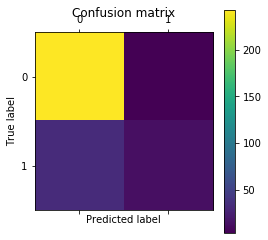

In [205]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_predictions)

print(cm)

# Show confusion matrix in a separate window
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [206]:
# One Prediction
instance_num = 6
# Get the prediction for the first member of the test set and explain why model made that prediction
prediction_value = original_model.predict(x_test)[instance_num]

print("One Prediction: ")
print(prediction_value)

print(y_predictions[:20])

x_test.head(20)

One Prediction: 
0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
899,49,Travel_Rarely,1098,Research & Development,4,2,Medical,1,Male,85,...,3,3,1,23,2,4,1,0,0,0
610,27,Travel_Rarely,269,Research & Development,5,1,Technical Degree,3,Male,42,...,3,2,1,9,3,3,9,8,0,8
667,41,Travel_Rarely,1085,Research & Development,2,4,Life Sciences,2,Female,57,...,3,3,1,10,1,2,7,7,1,0
857,44,Travel_Rarely,1097,Research & Development,10,4,Life Sciences,3,Male,96,...,3,3,0,6,4,3,6,4,0,2
1063,29,Travel_Rarely,1246,Sales,19,3,Life Sciences,3,Male,77,...,3,3,2,10,3,3,10,7,0,4
1022,37,Non-Travel,1413,Research & Development,5,2,Technical Degree,3,Male,84,...,3,1,0,7,2,1,6,5,1,3
665,47,Travel_Rarely,1454,Sales,2,4,Life Sciences,4,Female,65,...,3,1,0,3,3,2,3,2,1,2
840,35,Travel_Rarely,982,Research & Development,1,4,Medical,4,Male,58,...,3,2,1,10,2,3,8,0,1,7
796,25,Travel_Rarely,1219,Research & Development,4,1,Technical Degree,4,Male,32,...,3,2,1,7,3,4,7,7,5,6
1221,45,Non-Travel,1238,Research & Development,1,1,Life Sciences,3,Male,74,...,4,4,1,25,3,2,23,15,14,4


In [207]:
y_test.head(5)

899     0
610     0
667     1
857     1
1063    0
Name: Attrition, dtype: int64